# Importing required libraries

In [1]:
!pip install torch_snippets torch_summary --quiet

import os
import glob
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
from itertools import chain
from torch.cuda.amp import GradScaler, autocast
from google.colab import drive

# Set device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Mount Google Drive
drive.mount('/content/drive')


Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Looking at what the shape of our training images are

In [2]:
# Check image dimensions by loading one sample image
sample_img = Image.open('/content/drive/MyDrive/Deep Learning/Assignment/HW6/HW_06 Dataset/trainA/00001.jpg')
print(f"Image Size: {sample_img.size}")  # Output: (256, 256)


Image Size: (256, 256)


In [3]:
torch.cuda.empty_cache()

### Defining image transformations (augmentation)

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])


In [6]:
class Photo2MonetDataset(Dataset):
    def __init__(self, photo_path, monet_path, transform=None):
        self.photos = self._get_files(photo_path)
        self.monets = self._get_files(monet_path)
        self.transform = transform

    def _get_files(self, path):
        return glob.glob(os.path.join(path, '*.jpg')) + glob.glob(os.path.join(path, '*.png'))

    def __len__(self):
        return max(len(self.photos), len(self.monets))

    def __getitem__(self, idx):
        photo = Image.open(self.photos[idx % len(self.photos)]).convert('RGB')
        monet = Image.open(random.choice(self.monets)).convert('RGB')
        if self.transform:
            photo = self.transform(photo)
            monet = self.transform(monet)
        return photo, monet


### Making our Train and Test Dataset

In [7]:
train_photo_path = "/content/drive/MyDrive/Deep Learning/Assignment/HW6/HW_06 Dataset/trainA"
train_monet_path = "/content/drive/MyDrive/Deep Learning/Assignment/HW6/HW_06 Dataset/trainB"

train_dataset = Photo2MonetDataset(train_photo_path, train_monet_path, transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True,persistent_workers=True)


In [8]:
test_photo_path = "/content/drive/MyDrive/Deep Learning/Assignment/HW6/HW_06 Dataset/testA"
test_monet_path = "/content/drive/MyDrive/Deep Learning/Assignment/HW6/HW_06 Dataset/testB"

test_dataset = Photo2MonetDataset(test_photo_path, test_monet_path, transform)

test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True, num_workers=2, pin_memory=True,persistent_workers=True)


In [9]:
from torch.amp import GradScaler, autocast


### Defining a Residual Block

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)


### Generator Class

In [11]:
class GeneratorResNet(nn.Module):
    def __init__(self, num_residual_blocks=4):
        super(GeneratorResNet, self).__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, in_features * 2, 3, stride=2, padding=1),
                nn.InstanceNorm2d(in_features * 2),
                nn.ReLU(inplace=True)
            ]
            in_features *= 2

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        for _ in range(2):
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, in_features // 2, 3, padding=1),
                nn.InstanceNorm2d(in_features // 2),
                nn.ReLU(inplace=True)
            ]
            in_features //= 2

        model += [nn.ReflectionPad2d(3), nn.Conv2d(in_features, 3, 7), nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


### Discriminator Class

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)


### we generate samples from our Cycle GAN

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transfer models to the selected device
G_AB = GeneratorResNet().to(device)  # Photo to Monet
G_BA = GeneratorResNet().to(device)  # Monet to Photo
D_A = Discriminator().to(device)     # Real Photos
D_B = Discriminator().to(device)     # Real Monets

criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# optimizer_G = optim.Adam(chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))
# optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
# optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = optim.Adam(
    chain(G_AB.parameters(), G_BA.parameters()),
    lr=0.0002, betas=(0.5, 0.999)
)


In [14]:
from torch.amp import GradScaler

### Defining the Generator Training Step

In [15]:
scaler = GradScaler(device='cuda')  # Mixed precision scaler

def train_generator(real_A, real_B):
    for param in D_A.parameters():
        param.requires_grad = False  # Freeze discriminator A
    for param in D_B.parameters():
        param.requires_grad = False  # Freeze discriminator B

    optimizer_G.zero_grad()

    with autocast(device_type='cuda', dtype=torch.float16):
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.ones_like(D_B(fake_B)).to(device))

        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.ones_like(D_A(fake_A)).to(device))

        loss_cycle_A = criterion_cycle(G_BA(fake_B), real_A)
        loss_cycle_B = criterion_cycle(G_AB(fake_A), real_B)

        loss_identity_A = criterion_identity(G_BA(real_A), real_A)
        loss_identity_B = criterion_identity(G_AB(real_B), real_B)

        loss_G = loss_GAN_AB + loss_GAN_BA + 10 * (loss_cycle_A + loss_cycle_B) + 5 * (loss_identity_A + loss_identity_B)

    scaler.scale(loss_G).backward()  # Use mixed precision scaler
    scaler.step(optimizer_G)
    scaler.update()

    return loss_G.item()


### Defining the Discriminator Training Step

In [ ]:
def train_discriminator(D, real, fake, optimizer):
    D.train()  # Set to train mode
    for param in D.parameters():
        param.requires_grad = True  # Ensure gradients are enabled

    optimizer.zero_grad()
    real_loss = criterion_GAN(D(real), torch.ones_like(D(real)).to(device))
    fake_loss = criterion_GAN(D(fake.detach()), torch.zeros_like(D(fake)).to(device))
    loss_D = (real_loss + fake_loss) / 2
    loss_D.backward()
    optimizer.step()

    return loss_D.item()

In [16]:
@torch.no_grad()
def generate_and_show_test_samples(generator_AB, generator_BA, test_loader):
    """Generate and display results from testA and testB datasets."""
    real_photos, real_monets = next(iter(test_loader))
    real_photos, real_monets = real_photos.to(device), real_monets.to(device)

    # Generate fake Monet and fake photo images
    fake_monets = generator_AB(real_photos)  # Photo → Monet
    fake_photos = generator_BA(real_monets)  # Monet → Photo

    # Create grids for visualization
    real_photos_grid = make_grid(real_photos, nrow=5, normalize=True, value_range=(-1, 1))
    real_monets_grid = make_grid(real_monets, nrow=5, normalize=True, value_range=(-1, 1))
    fake_monets_grid = make_grid(fake_monets, nrow=5, normalize=True, value_range=(-1, 1))
    fake_photos_grid = make_grid(fake_photos, nrow=5, normalize=True, value_range=(-1, 1))

    # Display the images
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(real_photos_grid.permute(1, 2, 0).cpu().numpy())
    plt.title('Real Photos (testA)')

    plt.subplot(2, 2, 2)
    plt.imshow(fake_monets_grid.permute(1, 2, 0).cpu().numpy())
    plt.title('Photo → Monet (Generated)')

    plt.subplot(2, 2, 3)
    plt.imshow(real_monets_grid.permute(1, 2, 0).cpu().numpy())
    plt.title('Real Monets (testB)')

    plt.subplot(2, 2, 4)
    plt.imshow(fake_photos_grid.permute(1, 2, 0).cpu().numpy())
    plt.title('Monet → Photo (Generated)')
    plt.show()


### Training the CYCLE GAN. Increase the number of epochs for better results

Epoch [1/10] - loss_D_A: 0.1875, loss_D_B: 0.1925, loss_G: 8.1260, time: 1367.63s


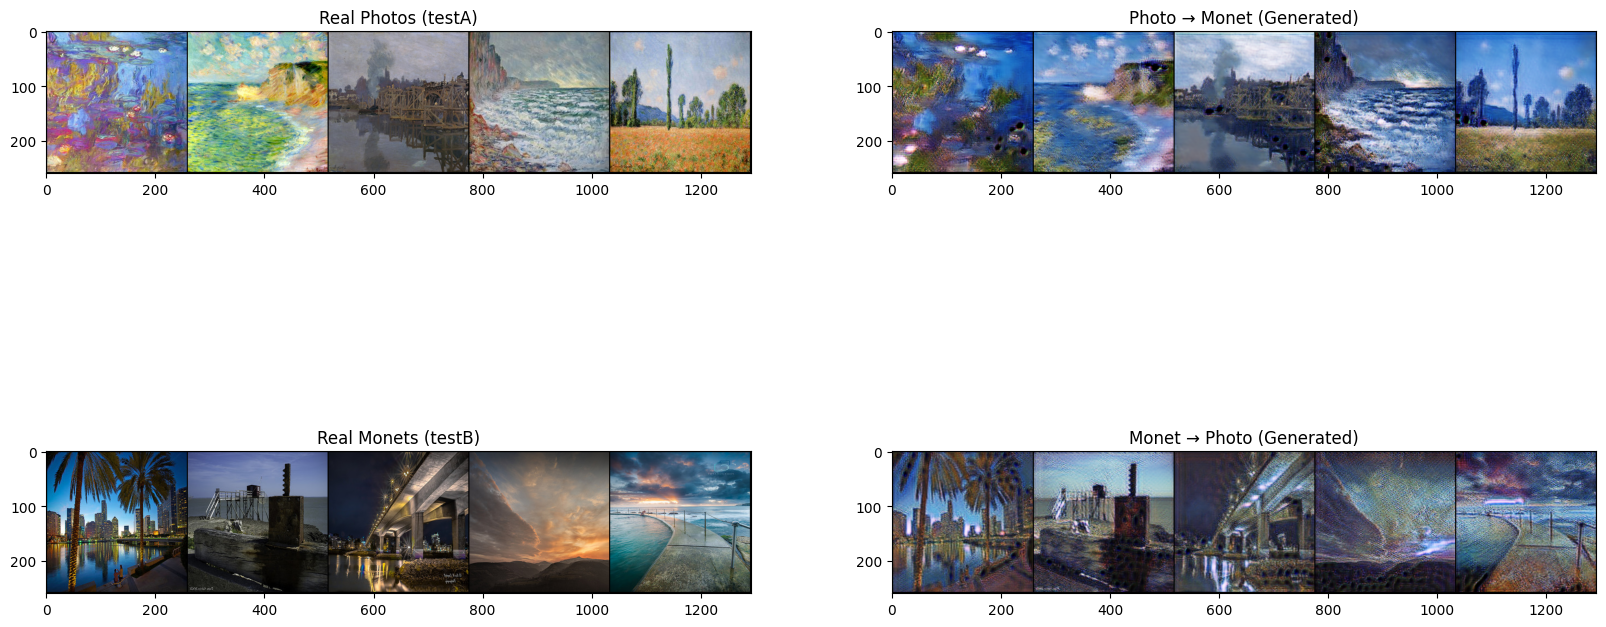

Epoch [2/10] - loss_D_A: 0.1834, loss_D_B: 0.1831, loss_G: 6.9470, time: 1353.90s
Epoch [3/10] - loss_D_A: 0.1326, loss_D_B: 0.1904, loss_G: 6.6168, time: 1350.87s
Epoch [4/10] - loss_D_A: 0.1807, loss_D_B: 0.1751, loss_G: 6.3272, time: 1356.79s
Epoch [5/10] - loss_D_A: 0.2345, loss_D_B: 0.1727, loss_G: 5.5873, time: 1352.62s
Epoch [6/10] - loss_D_A: 0.1833, loss_D_B: 0.1703, loss_G: 5.9988, time: 1351.67s


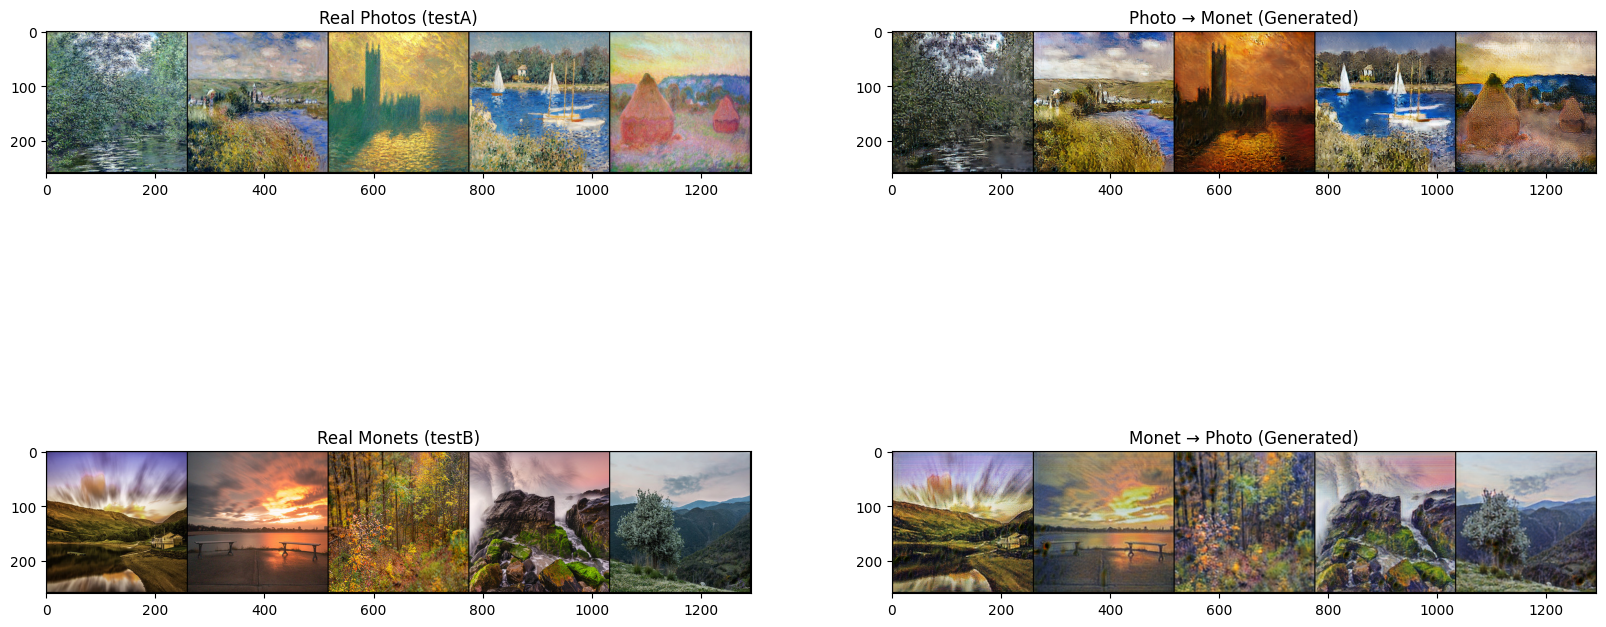

Epoch [7/10] - loss_D_A: 0.1278, loss_D_B: 0.1799, loss_G: 5.7048, time: 1351.40s
Epoch [8/10] - loss_D_A: 0.0729, loss_D_B: 0.1724, loss_G: 5.7529, time: 1351.49s
Epoch [9/10] - loss_D_A: 0.0969, loss_D_B: 0.1714, loss_G: 5.6599, time: 1350.27s
Epoch [10/10] - loss_D_A: 0.0634, loss_D_B: 0.1691, loss_G: 5.6611, time: 1351.74s
Training complete!
Models saved successfully!
CPU times: user 2h 51min 33s, sys: 48min 34s, total: 3h 40min 8s
Wall time: 3h 45min 53s


In [17]:
%%time
# Training Loop
losses = {'G': [], 'D_A': [], 'D_B': []}
n_epochs = 10
for epoch in range(n_epochs):
    epoch_start_time = time.time()
    G_loss, D_A_loss, D_B_loss = 0, 0, 0

    for real_A, real_B in train_loader:
        real_A, real_B = real_A.to(device), real_B.to(device)

        # Train Discriminators
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        D_A_loss += train_discriminator(D_A, real_A, fake_A, optimizer_D_A)
        D_B_loss += train_discriminator(D_B, real_B, fake_B, optimizer_D_B)

        # Train Generators
        G_loss += train_generator(real_A, real_B)

    # Store average losses
    losses['G'].append(G_loss / len(train_loader))
    losses['D_A'].append(D_A_loss / len(train_loader))
    losses['D_B'].append(D_B_loss / len(train_loader))

    # Log losses
    print(f"Epoch [{epoch + 1}/{n_epochs}] - "
          f"loss_D_A: {D_A_loss / len(train_loader):.4f}, "
          f"loss_D_B: {D_B_loss / len(train_loader):.4f}, "
          f"loss_G: {G_loss / len(train_loader):.4f}, "
          f"time: {time.time() - epoch_start_time:.2f}s")
    if epoch % 5 == 0:
      generate_and_show_test_samples(G_AB, G_BA, test_loader)
print("Training complete!")

# Save the trained generator models after training
torch.save(G_AB.state_dict(), '/content/drive/MyDrive/Deep Learning/Assignment/HW6/G_AB.pth')  # Photo to Monet
torch.save(G_BA.state_dict(), '/content/drive/MyDrive/Deep Learning/Assignment/HW6/G_BA.pth')  # Monet to Photo

print("Models saved successfully!")


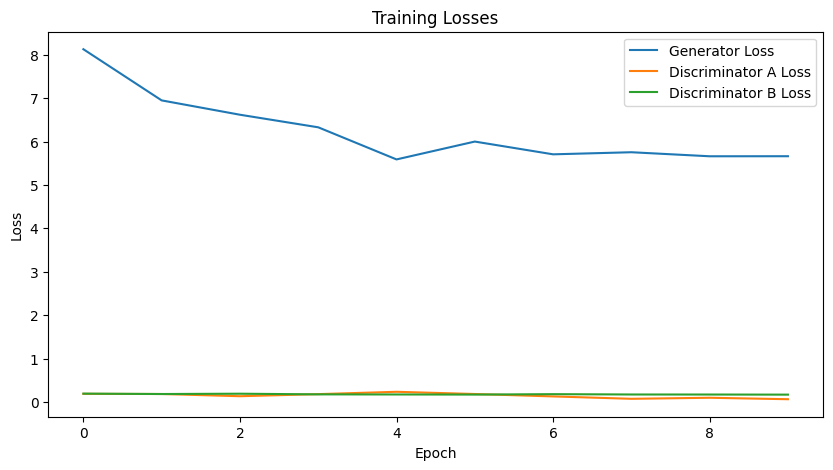

In [18]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(losses['G'], label='Generator Loss')
plt.plot(losses['D_A'], label='Discriminator A Loss')
plt.plot(losses['D_B'], label='Discriminator B Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.show()

In [28]:
# Load the trained models for inference
G_AB = GeneratorResNet().to(device)  # Photo to Monet
G_BA = GeneratorResNet().to(device)  # Monet to Photo

# G_AB.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning/Assignment/HW6/G_AB.pth'))
# G_BA.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning/Assignment/HW6/G_BA.pth'))
# Load only the state_dict (weights) from the .pth files
G_AB.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning/Assignment/HW6/G_AB.pth', weights_only=True))
G_BA.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning/Assignment/HW6/G_BA.pth', weights_only=True))

# Set models to evaluation mode
G_AB.eval()
G_BA.eval()

print("Models loaded successfully!")


Models loaded successfully!


In [29]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

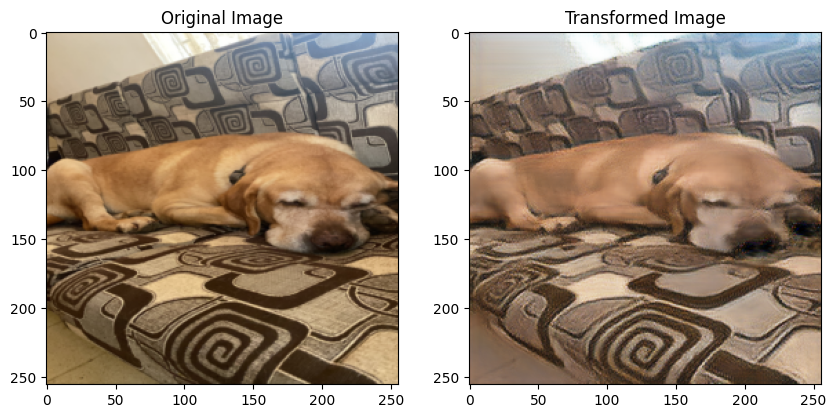

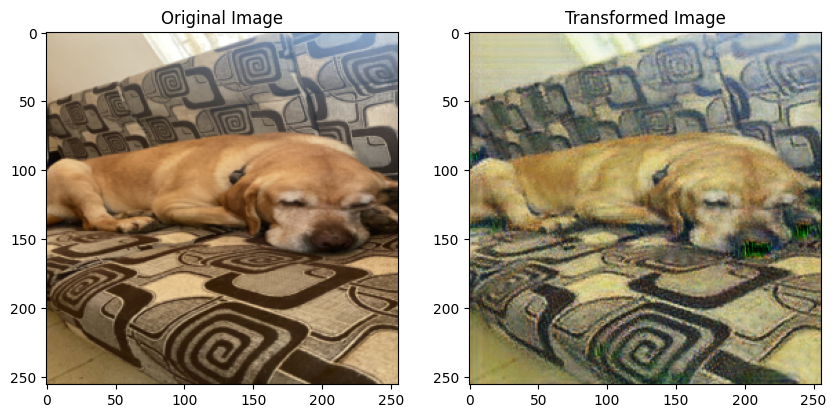

In [30]:
def denormalize(tensor):
    """Denormalize the tensor from [-1, 1] to [0, 1]."""
    return tensor * 0.5 + 0.5

def generate_for_single_image(generator, image_path, transform):
    """Load a single image and apply the generator to transform it."""
    # Load and transform the image
    image = load_and_transform_image(image_path, transform)

    # Generate the transformed image
    with torch.no_grad():
        generated_image = generator(image)

    # Denormalize for visualization
    input_grid = denormalize(make_grid(image, normalize=False))
    output_grid = denormalize(make_grid(generated_image, normalize=False))

    # Visualize the input and output
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(input_grid.permute(1, 2, 0).cpu().numpy())
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(output_grid.permute(1, 2, 0).cpu().numpy())
    plt.title('Transformed Image')

    plt.show()

# Apply Photo → Monet transformation
generate_for_single_image(G_AB, "/content/drive/MyDrive/Deep Learning/Assignment/HW6/Tito.jpg", transform)

# Apply Monet → Photo transformation
generate_for_single_image(G_BA, "/content/drive/MyDrive/Deep Learning/Assignment/HW6/Tito.jpg", transform)


# CycleGAN Report

## Introduction
The CycleGAN model handles image-to-image translation across two visual domains where paired training data is not available. The project task is to convert photographs to Monet-style paintings and vice versa to demonstrate flexibility in GANs style transfer.

## Dataset and Preprocessing
• Training Data: Two datasets, one containing photos and the other containing Monet paintings.
- **Image Size**: Images were resized to 256x256 pixels.
- **Transformations**: Data augmentation like random horizontal flip and normalizing did for better generalization.

## Architecture
1. **Generators**: There exists a pair of generators, which are G_AB:
   - **G_AB**: Takes photos and converts them into Monet paintings.
   - **G_BA**: Takes Monet paintings and converts them back into photos.
   - Each generator consists of **residual blocks** that help in the proper transformation of features and produces more smooth results.

2. **Discriminators**: Two discriminators (D_A and D_B):
	* **D_A**: Discriminates between real and generated photos.
	* **D_B**: Discriminates between real Monet paintings and the generated ones.

## Training Process
- **Optimization**: For both generators and discriminators, Adam optimizer was used with:
  - Learning rate: 0.0002
  - Momentum: \\((\\beta_1=0.5, \\beta_2=0.999)\\)

- **Mixed Precision Training**: 
  - GradScaler made sure the training on GPU is both faster and more memory-efficient.

- **Training for 10 Epochs**:
  - Generators and discriminators are trained iteratively for minimizing GAN, cycle, and identity losses.

## Results of Training and Loss Trends
In this training for 10 epochs, the model has steadily converged into the losses from both generators and discriminators. Following are the broad trends:

- **Generator Loss (G)**: 
  - This decreases over time, which indicates that the generators get better over time at fooling the discriminators.
- **Final Epoch Loss (Generator)**: 5.6611

- **Discriminator Losses (D_A and D_B)**:
  - **D_A Loss**: This is a measure of the success of the discriminator in recognizing real photos from the generated ones.
    - **Started**: 0.1875 → **Ended:** 0.0634
  - **D_B Loss**: This is the measure of efficiency for the discriminator in identifying the real Monet paintings from those that were generated.
    - **Started:** 0.1925 → **END
 Epoch [1/10] - loss_D_A: 0.1875, loss_D_B: 0.1925, loss_G: 8.1260 
 Epoch [5/10] - loss_D_A: 0.2345, loss_D_B: 0.1727, loss_G: 5.5873 
 Epoch [10/10] - loss_D_A: 0.0634, loss_D_B: 0.1691, loss_G: 5.6611

### **Loss Graphs**:
- Plotted the losses to see the general trends across the epochs:
 - **Generator Loss**: This continuously decreases, showing the quality of generation increases.
- **Discriminator A and B Losses**: Very volatile at the beginning, yet stabilized while continuing with the training process.

## Visual Results
- **Photo → Monet Transformation**: The paintings were generated in the artistic style of Monet.
- **Monet → Photo Transformation:** Transformed images resembled natural photos without much distortion.

## Conclusion
The CycleGAN model has effectively learned the translation between two unpaired visual domains.
- **Key Achievements:**
- It showed stable training with the model, where losses decrease monotonically.
 - Converging losses signal a balance in the competition between generators and discriminators.
 - The outputs generated were stylistically faithful while maintaining most of the key features of the input images.

With more epochs, it might reach an even finer level of visual quality. This assignment, in general, shows the power of CycleGAN in complex style transfer tasks where paired datasets are not available.